In [2]:
# np.random.seed(666)
import pandas as pd
import sys
sys.path.append("../src/")
from alive_progress import alive_bar
from project_package.generate_pop import SymPop
from project_package.generate_pop import generate_initial_pop_unlinked
from project_package.run_model import update_pop, update_pop_with_tracers,update_pop2_with_tracers
import tracemalloc
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Parallelization

The way it is written now, the model parallelizes over the number of individual hosts; 1cpu/host


## toy example [10,40,100] worms + cpus(10 to 1, every 2) 

record: time to run one generation, time to run the whole script (incl. writting output files)

In [18]:
time_df=pd.DataFrame([], columns=['test','nworms','cpus','time_run','time_write','time_tot'])
mylist=[[10,10],[4,10],[2,10],[1,10],
        [10,100],[4,100],[2,100],
        [10,1000],[4,1000],[2,1000],
        [10,10000],[4,10000]
       ]

time_df.iloc[:,0]=['toy_example1_'+str(w)+'worms_'+str(cpus)+'cpus' for cpus,w in mylist]
time_df.iloc[:,1]=[w for cpus,w in mylist]
time_df.iloc[:,2]=[cpus for cpus,w in mylist]
time_df

,test,nworms,cpus,time_run,time_write,time_tot
0,toy_example1_10worms_10cpus,10,10,NaN,NaN,NaN
1,toy_example1_10worms_4cpus,10,4,NaN,NaN,NaN
2,toy_example1_10worms_2cpus,10,2,NaN,NaN,NaN
3,toy_example1_10worms_1cpus,10,1,NaN,NaN,NaN
4,toy_example1_100worms_10cpus,100,10,NaN,NaN,NaN
5,toy_example1_100worms_4cpus,100,4,NaN,NaN,NaN
6,toy_example1_100worms_2cpus,100,2,NaN,NaN,NaN
7,toy_example1_1000worms_10cpus,1000,10,NaN,NaN,NaN
8,toy_example1_1000worms_4cpus,1000,4,NaN,NaN,NaN
9,toy_example1_1000worms_2cpus,1000,2,NaN,NaN,NaN


In [19]:
import pickle
import pandas as pd
import sys
# sys.path.append("/Users/maeva/Desktop/Modeling_trophosome/src/")
sys.path.append("/home/qiulab/data/CRF_project/work/Modeling_trophosome/src/")

from project_package.generate_pop import generate_initial_pop_unlinked, generate_random_fisherlog_pop_unlinked,generate_random_fisherlog_pop_binomial_tree, SymPop
from project_package.update_pop import update_pop3
from project_package.run_model import run_generation_of_host_pop
from project_package.plot import visualize_pop
from project_package.simplify import merge_graphs

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from alive_progress import alive_bar

import time
import warnings

# import seaborn as sns
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# np.random.seed(666)

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

# with open('../examples/investigate_scaling_up/toy_example1_times.txt','w') as fa:
#     fa.write('')
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

    for mytestparams in time_df.values:
    
        test=mytestparams[0]
        
        ## init results objects    
        time_series_freeliving={}
        time_series_hostassociated={}
        
        ## params grow_and_steady
        mutation_rate=1E-12
        growth_factor=1.2
        steady_state_runtime=50
        max_runtime=np.inf
        pop_size_thr=1E4
        simplify=1
        verbose=0
        sampling_rate=1
        
        ## params run_host_pop_gen
        n_worms=mytestparams[1]
        infection_sym_count=10
        tot_host_pop_gen=20
        escape_rate=1E-2
        n_trials=1
        cpus=mytestparams[2]
        
        # init tree log-fisher
        init_pop_strains=100
        is_init_pop_log_fisher=True
        
        if is_init_pop_log_fisher==True:  
            freelivingG=generate_random_fisherlog_pop_unlinked(i=init_pop_strains) #n=individuals, i=strains
            freelivingG=nx.relabel_nodes(freelivingG, dict([[i,'0.0.'+str(i)] for i in range(init_pop_strains)]))
            
        ## init tree
        
        # fitnesses=[0.95,0.9] # allele_id:fitness
        # abundances=[300000000,700000000] # allele_id:abundance # total 1G cells
        # freelivingG=generate_initial_pop_unlinked(fitnesses,abundances)
        # freelivingG=nx.relabel_nodes(freelivingG, {0:'0.0.0',1:'0.0.1'})
        # time_series_freeliving[0]=freelivingG
        
        
        
        
        myparams=['## params grow_and_steady',
        'mutation_rate='+str(mutation_rate),
        'growth_factor='+str(growth_factor),
        'steady_state_runtime='+str(steady_state_runtime),
        'max_runtime='+str(max_runtime),
        'pop_size_thr='+str(pop_size_thr),
        'simplify='+str(simplify),
        'verbose='+str(verbose),
        'sampling_rate='+str(sampling_rate),
        '',
        '## params run_host_pop_gen',
        'n_worms='+str(n_worms),
        'infection_sym_count='+str(infection_sym_count),
        'tot_host_pop_gen='+str(tot_host_pop_gen),
        'escape_rate='+str(escape_rate),
        'n_trials='+str(n_trials),
        'cpus='+str(cpus),
        '',
        '## init tree',
        'init_pop_strains='+str(init_pop_strains),
        'is_init_pop_log_fisher='+str(is_init_pop_log_fisher)]
        
        
        print(SymPop(freelivingG).pop_size)
        time_series_freeliving[0]=freelivingG
        
        
        ###############################
        ## init results objects    
        time_series_freeliving={}
        time_series_hostassociated={}
        print('test=',test,'n_worms=',n_worms,'cpus=',cpus)
        start_time=time.time()
        
        # with alive_bar((tot_host_pop_gen+1) * n_trials ,force_tty=True) as bar:
        for trial in range(n_trials):
            host_pop_gen=0
            time_series_freeliving[trial]=[freelivingG]
            time_series_hostassociated[trial]=[nx.Graph()]
            myfreelivingG=freelivingG.copy()
        
            for host_pop_gen in range(1,tot_host_pop_gen+1):
            
                merged_Graph_hostassociated, merged_Graph_freeliving,_=run_generation_of_host_pop(myfreelivingG, n_worms, infection_sym_count,host_pop_gen,escape_rate,
                                     mutation_rate, steady_state_runtime,
                                     max_runtime, growth_factor=growth_factor,
                                     stop_when_fixed=True, pop_size_thr=pop_size_thr, simplify=simplify,
                                     verbose=verbose, t=0,sampling_rate=sampling_rate,nthreads=cpus)
                
                time_series_hostassociated[trial]+=[merged_Graph_hostassociated]
                time_series_freeliving[trial]+=[merged_Graph_freeliving]
                myfreelivingG=merged_Graph_freeliving
                    
                    # bar() 
    
        time_run=time.time()-start_time
        # time_df.loc[time_df.test==test,'time_run']=time_run
        ###########
        
        
        dump_dir='../examples/'
        
        with open(dump_dir+test+'.input_params.txt', 'w') as fa:
            fa.write('\n'.join(myparams))
        
        with open(dump_dir+test+'.time_series_hostassociated.txt', 'wb') as handle:
          pickle.dump(time_series_hostassociated, handle)
        
        with open(dump_dir+test+'.time_series_freeliving.txt', 'wb') as handle:
          pickle.dump(time_series_freeliving, handle)
    
        time_write=time.time()
        # time_df.loc[time_df.test==test,'time_write']=time_write-time_run
    
        # time_df.loc[time_df.test==test,'time_tot']=time_write-start_time
        appended_line='\t'.join(test,str(n_worms),str(cpus),str(time_write-time_run),str(time_run))
        with open('../examples/investigate_scaling_up/toy_example1_times.txt','a') as fa:
            fa.write(appended_line+'\n')




3734
test= toy_example1_10worms_10cpus n_worms= 10 cpus= 10
3911
test= toy_example1_10worms_4cpus n_worms= 10 cpus= 4
4056
test= toy_example1_10worms_2cpus n_worms= 10 cpus= 2
2365
test= toy_example1_10worms_1cpus n_worms= 10 cpus= 1
3062
test= toy_example1_100worms_10cpus n_worms= 100 cpus= 10
4191
test= toy_example1_100worms_4cpus n_worms= 100 cpus= 4
3552
test= toy_example1_100worms_2cpus n_worms= 100 cpus= 2
3261
test= toy_example1_1000worms_10cpus n_worms= 1000 cpus= 10
3928
test= toy_example1_1000worms_4cpus n_worms= 1000 cpus= 4
3383
test= toy_example1_1000worms_2cpus n_worms= 1000 cpus= 2
2478
test= toy_example1_10000worms_10cpus n_worms= 10000 cpus= 10
3452
test= toy_example1_10000worms_4cpus n_worms= 10000 cpus= 4


In [20]:
df=time_df.melt(id_vars=['test','nworms','cpus'])


,test,nworms,cpus,variable,value
0,toy_example1_10worms_10cpus,10,10,time_run,5.631855
1,toy_example1_10worms_4cpus,10,4,time_run,4.676822
2,toy_example1_10worms_2cpus,10,2,time_run,3.295231
3,toy_example1_10worms_1cpus,10,1,time_run,3.051675
4,toy_example1_100worms_10cpus,100,10,time_run,12.743247
5,toy_example1_100worms_4cpus,100,4,time_run,14.554067
6,toy_example1_100worms_2cpus,100,2,time_run,16.559118
7,toy_example1_1000worms_10cpus,1000,10,time_run,127.75503
8,toy_example1_1000worms_4cpus,1000,4,time_run,136.989747
9,toy_example1_1000worms_2cpus,1000,2,time_run,160.798556


In [44]:
time_df.to_csv('../examples/investigate_scaling_up/toy_example1_times.txt',header=True,sep='\t')

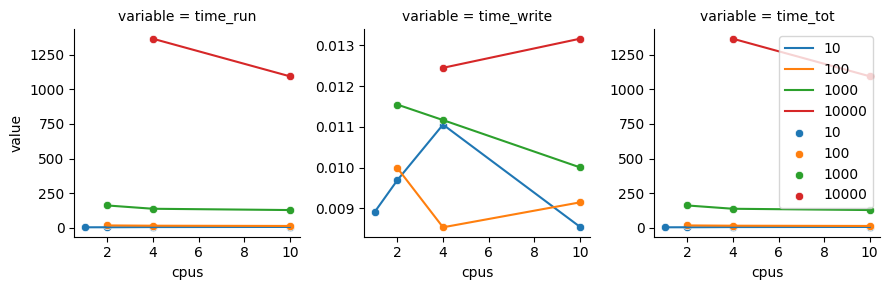

In [23]:
import seaborn as sns
g = sns.FacetGrid(df[df.nworms<100000], hue="nworms",col='variable',sharey=False)
g.map(sns.lineplot,'cpus','value')
g.map(sns.scatterplot,'cpus','value')

plt.legend()
# ax = g.ax_joint
# ax.set_yscale('log')

In [30]:
df[(df.cpus==10 )& (df.variable=='time_run')]

,test,nworms,cpus,variable,value
0,toy_example1_10worms_10cpus,10,10,time_run,5.631855
4,toy_example1_100worms_10cpus,100,10,time_run,12.743247
7,toy_example1_1000worms_10cpus,1000,10,time_run,127.75503
10,toy_example1_10000worms_10cpus,10000,10,time_run,1094.733551


In [42]:
df[(df.cpus==5 )& (df.variable=='time_run')]

,test,nworms,cpus,variable,value


In [39]:
df[(df.nworms==10000)& (df.variable=='time_run')]

,test,nworms,cpus,variable,value
10,toy_example1_10000worms_10cpus,10000,10,time_run,1094.733551
11,toy_example1_10000worms_4cpus,10000,4,time_run,1366.06253


In [40]:
df[(df.nworms==100)& (df.variable=='time_run')]

,test,nworms,cpus,variable,value
4,toy_example1_100worms_10cpus,100,10,time_run,12.743247
5,toy_example1_100worms_4cpus,100,4,time_run,14.554067
6,toy_example1_100worms_2cpus,100,2,time_run,16.559118


In [45]:
time_df

,test,nworms,cpus,time_run,time_write,time_tot
0,toy_example1_10worms_10cpus,10,10,5.631855,0.008554,5.640409
1,toy_example1_10worms_4cpus,10,4,4.676822,0.011056,4.687878
2,toy_example1_10worms_2cpus,10,2,3.295231,0.009697,3.304928
3,toy_example1_10worms_1cpus,10,1,3.051675,0.008913,3.060587
4,toy_example1_100worms_10cpus,100,10,12.743247,0.009149,12.752395
5,toy_example1_100worms_4cpus,100,4,14.554067,0.008538,14.562605
6,toy_example1_100worms_2cpus,100,2,16.559118,0.00999,16.569107
7,toy_example1_1000worms_10cpus,1000,10,127.75503,0.01001,127.765039
8,toy_example1_1000worms_4cpus,1000,4,136.989747,0.011168,137.000914
9,toy_example1_1000worms_2cpus,1000,2,160.798556,0.011547,160.810103


## toy example 


In [78]:
time_df=pd.read_csv('/home/qiulab/data/CRF_project/scratch/Modeling_trophosome/Scaling_up_investigation/2025_10_28/times.txt',sep='\t',header=0)
df=time_df.melt(id_vars=['test','n_worms','cpus'])
df[df.test.str.contains('toy_example1')]
print(max(df[(df.test.str.contains('toy_example1')) & (df.variable=='run_time')].value.values),
     min(df[(df.test.str.contains('toy_example1')) & (df.variable=='run_time')].value.values))

1757.9135015010834 2.6209464073181152


In [77]:
df[df.test.str.contains('toy_example1')]

,test,n_worms,cpus,variable,value
0,toy_example1_40worms_8cpus,40,8,write_time,1.761659e+09
1,toy_example1_100worms_1cpus,100,1,write_time,1.761660e+09
2,toy_example1_1000worms_10cpus,1000,10,write_time,1.761660e+09
3,toy_example1_100worms_20cpus,100,20,write_time,1.761661e+09
4,toy_example1_100worms_40cpus,100,40,write_time,1.761661e+09
5,toy_example1_1000worms_20cpus,1000,20,write_time,1.761661e+09
6,toy_example1_1000worms_40cpus,1000,40,write_time,1.761661e+09
7,toy_example1_100worms_10cpus,100,10,write_time,1.761661e+09
8,toy_example1_100worms_2cpus,100,2,write_time,1.761661e+09
9,toy_example1_1000worms_2cpus,1000,2,write_time,1.761662e+09


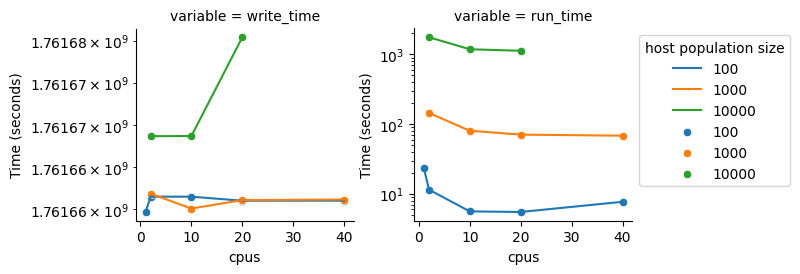

In [4]:
import seaborn as sns
g = sns.FacetGrid(df[(df.test.str.contains('toy_example1')) & (df.n_worms!=40)], hue="n_worms",col='variable',sharey=False)
g.map(sns.lineplot,'cpus','value')
g.map(sns.scatterplot,'cpus','value')
g.set(yscale='log')
g.set(ylabel='Time (seconds)')

plt.legend(bbox_to_anchor=(1, 1),title="host population size")

### Symbiont Pop param vs host pop size

/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/qiulab/CRF_project/work/Modeling_trophosome/notebooks/../src/project_package/generate_pop.py:129: RuntimeWarning: divide by zero encountered in log
  self.eveness=self.Shannon/np.log(self.richness)
/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/qi

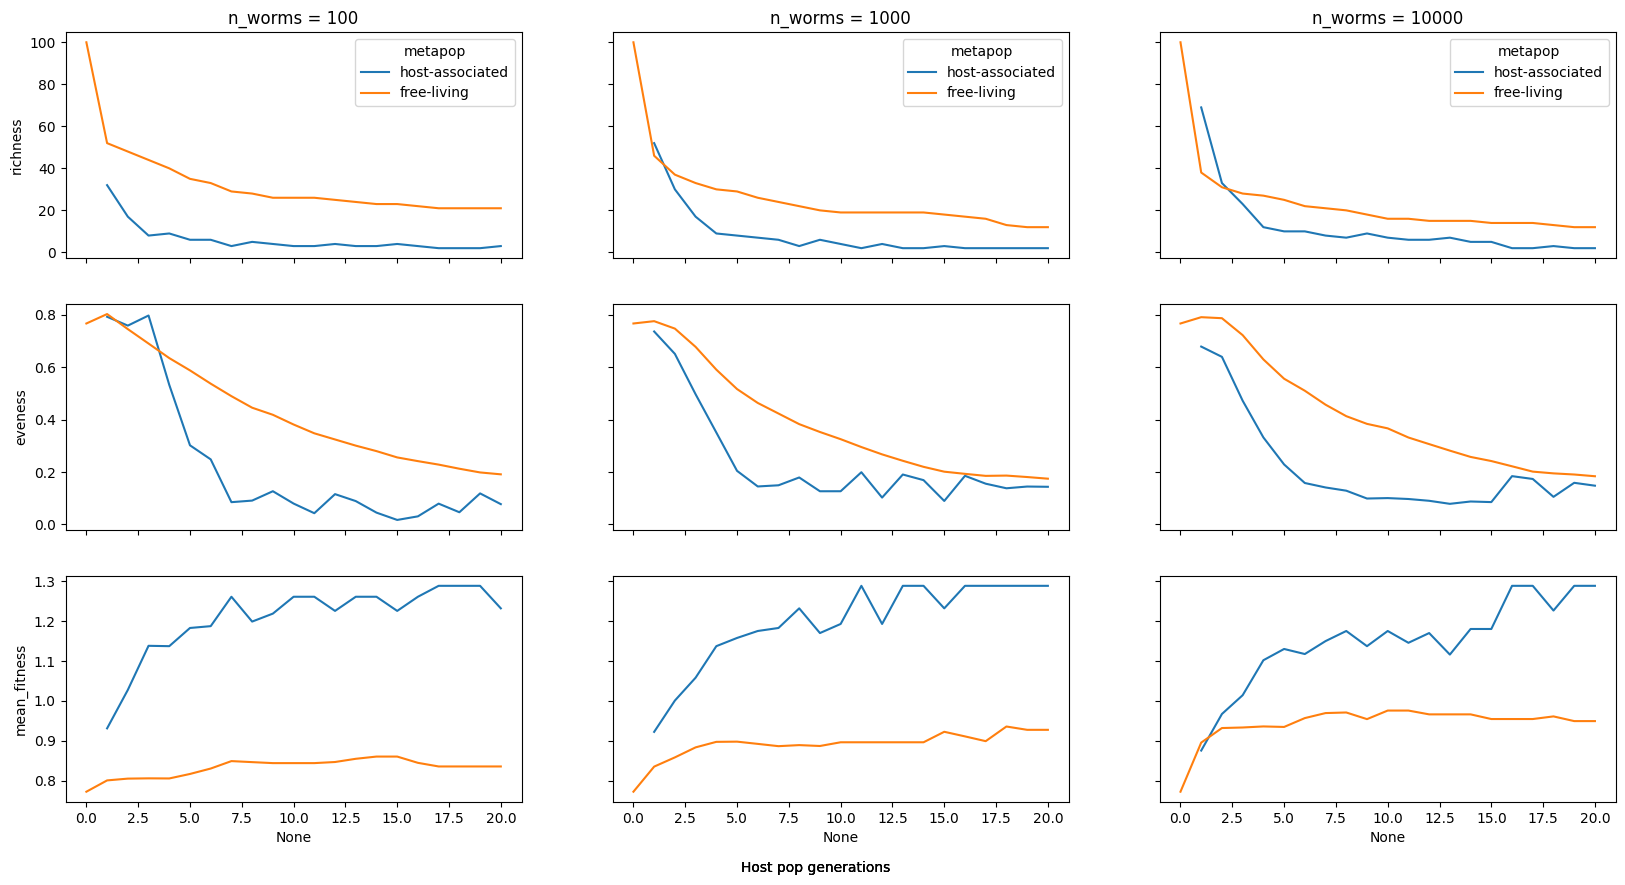

In [11]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from project_package.generate_pop import SymPop
import seaborn as sns

fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey='row')

i=0

for n_worms in [100,1000,10000]:

    with open('/home/qiulab/data/CRF_project/scratch/Modeling_trophosome/Scaling_up_investigation/2025_10_28/toy_example1_'+str(n_worms)+'worms_10cpus.time_series_hostassociated.graphs.pickledump', 'rb') as handle:
      time_series_hostassociated=pickle.loads(handle.read())
        
    with open('/home/qiulab/data/CRF_project/scratch/Modeling_trophosome/Scaling_up_investigation/2025_10_28/toy_example1_'+str(n_worms)+'worms_10cpus.time_series_freeliving.graphs.pickledump', 'rb') as handle:
      time_series_freeliving=pickle.loads(handle.read())
    
    df=pd.DataFrame()
    for trial in time_series_freeliving.keys():
    
        time_series_hostassociated[trial][0]=nx.Graph(abundance=0)
        df2=pd.DataFrame([[SymPop(G).eveness, SymPop(G).mean_fitness, SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                                columns=['eveness','mean_fitness','pop_size','richness','metapop','trial'])
        df=pd.concat([df, df2])
    
        # if trial==0:
        #     continue
        df3=pd.DataFrame([[SymPop(G).eveness, SymPop(G).mean_fitness, SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                                columns=['eveness','mean_fitness','pop_size','richness','metapop','trial'])
        df=pd.concat([df, df3])
        
    axes[0,i].set_title('n_worms = '+str(n_worms))
    sns.lineplot(ax=axes[0,i], data=df[(df.pop_size>0)],x=df[(df.pop_size>0)].index,y='richness',hue='metapop',legend=True)
    sns.lineplot(ax=axes[1,i], data=df[(df.pop_size>0) & ~(df.eveness.isna())],x=df[(df.pop_size>0) & ~(df.eveness.isna())].index,y='eveness',hue='metapop',legend=False)
    sns.lineplot(ax=axes[2,i], data=df[(df.pop_size>0)],x=df[(df.pop_size>0)].index,y='mean_fitness',hue='metapop',legend=False)
    fig.text(0.5, 0.04, 'Host pop generations', ha='center')
    i+=1

### Symbiont Pop param vs cpus

/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/qiulab/CRF_project/work/Modeling_trophosome/notebooks/../src/project_package/generate_pop.py:129: RuntimeWarning: divide by zero encountered in log
  self.eveness=self.Shannon/np.log(self.richness)
/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/qi

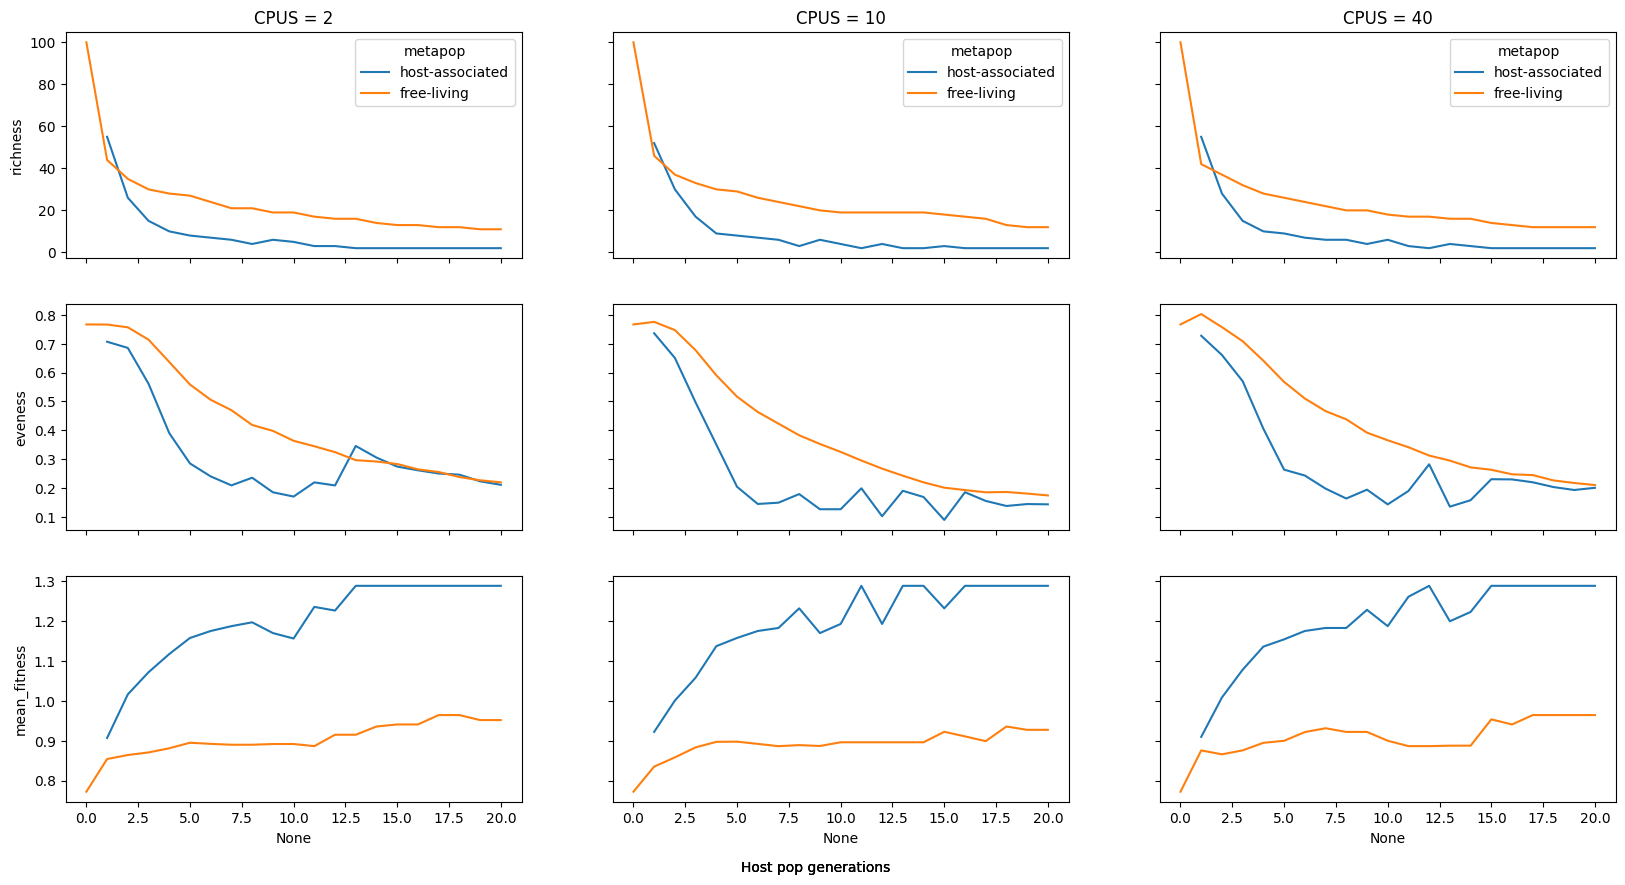

In [8]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from project_package.generate_pop import SymPop
import seaborn as sns

fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey='row')

i=0

for cpus in [2,10,40]:

    with open('/home/qiulab/data/CRF_project/scratch/Modeling_trophosome/Scaling_up_investigation/2025_10_28/toy_example1_1000worms_'+str(cpus)+'cpus.time_series_hostassociated.graphs.pickledump', 'rb') as handle:
      time_series_hostassociated=pickle.loads(handle.read())
        
    with open('/home/qiulab/data/CRF_project/scratch/Modeling_trophosome/Scaling_up_investigation/2025_10_28/toy_example1_1000worms_'+str(cpus)+'cpus.time_series_freeliving.graphs.pickledump', 'rb') as handle:
      time_series_freeliving=pickle.loads(handle.read())
    
    df=pd.DataFrame()
    for trial in time_series_freeliving.keys():
    
        time_series_hostassociated[trial][0]=nx.Graph(abundance=0)
        df2=pd.DataFrame([[SymPop(G).eveness, SymPop(G).mean_fitness, SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                                columns=['eveness','mean_fitness','pop_size','richness','metapop','trial'])
        df=pd.concat([df, df2])
    
        # if trial==0:
        #     continue
        df3=pd.DataFrame([[SymPop(G).eveness, SymPop(G).mean_fitness, SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                                columns=['eveness','mean_fitness','pop_size','richness','metapop','trial'])
        df=pd.concat([df, df3])
    
    axes[0,i].set_title('CPUS = '+str(cpus))
    sns.lineplot(ax=axes[0,i], data=df[(df.pop_size>0)],x=df[(df.pop_size>0)].index,y='richness',hue='metapop',legend=True)
    sns.lineplot(ax=axes[1,i], data=df[(df.pop_size>0) & ~(df.eveness.isna())],x=df[(df.pop_size>0) & ~(df.eveness.isna())].index,y='eveness',hue='metapop',legend=False)
    sns.lineplot(ax=axes[2,i], data=df[(df.pop_size>0)],x=df[(df.pop_size>0)].index,y='mean_fitness',hue='metapop',legend=False)
    fig.text(0.5, 0.04, 'Host pop generations', ha='center')


    i+=1

### Symbiont Pop param vs symb diversity (mutation_rate)

In [36]:
df=time_df[(time_df.n_worms==100) & (time_df.cpus==10)]
df['mutation_rate']=[1E-12,1E-11,1E-10,1E-09,1E-06,1E-03,1E-04,1E-05]
df=df.melt(id_vars=['test','n_worms','cpus','mutation_rate'])
df

/tmp/ipykernel_395135/2260476311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mutation_rate']=[1E-12,1E-11,1E-10,1E-09,1E-06,1E-03,1E-04,1E-05]


,test,n_worms,cpus,mutation_rate,variable,value
0,toy_example1_100worms_10cpus,100,10,1.000000e-12,write_time,1.761661e+09
1,toy_example2_100worms_10cpus,100,10,1.000000e-11,write_time,1.761663e+09
2,toy_example3_100worms_10cpus,100,10,1.000000e-10,write_time,1.761663e+09
3,toy_example4_100worms_10cpus,100,10,1.000000e-09,write_time,1.761663e+09
4,toy_example5_100worms_10cpus,100,10,1.000000e-06,write_time,1.761664e+09
5,toy_example6_100worms_10cpus,100,10,1.000000e-03,write_time,1.761664e+09
6,toy_example7_100worms_10cpus,100,10,1.000000e-04,write_time,1.761664e+09
7,toy_example8_100worms_10cpus,100,10,1.000000e-05,write_time,1.761665e+09
8,toy_example1_100worms_10cpus,100,10,1.000000e-12,run_time,5.594924e+00
9,toy_example2_100worms_10cpus,100,10,1.000000e-11,run_time,5.736174e+00


['toy_example1_100worms_10cpus' 'toy_example2_100worms_10cpus'
 'toy_example3_100worms_10cpus' 'toy_example4_100worms_10cpus'
 'toy_example5_100worms_10cpus' 'toy_example8_100worms_10cpus'
 'toy_example7_100worms_10cpus' 'toy_example6_100worms_10cpus']


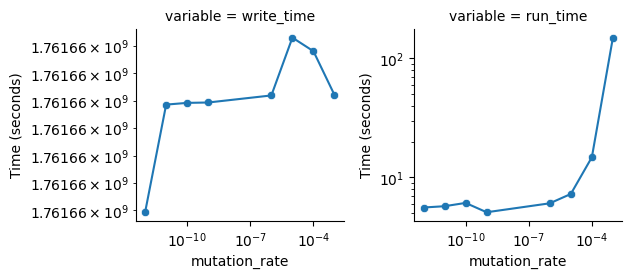

In [41]:
import seaborn as sns
g = sns.FacetGrid(df[(df.test.str.contains('toy_example')) & (df.n_worms!=40)],col='variable',sharey=False)
g.map(sns.scatterplot,'mutation_rate','value')
g.map(sns.lineplot,'mutation_rate','value')

g.set(yscale='log',xscale='log')
g.set(ylabel='Time (seconds)')

print(df[df.variable=='run_time'].sort_values('mutation_rate').test.values)

/tmp/ipykernel_395135/2492240661.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mutation_rate']=[1E-12,1E-11,1E-10,1E-09,1E-06,1E-03,1E-04,1E-05]
/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/qiulab/CRF_project/work/Modeling_trophosome/notebooks/../src/project_package/generate_pop.py:129: RuntimeWarning: divide by zero encountered in log
  self.eveness=self.Shannon/np.log(self.richness)
/h

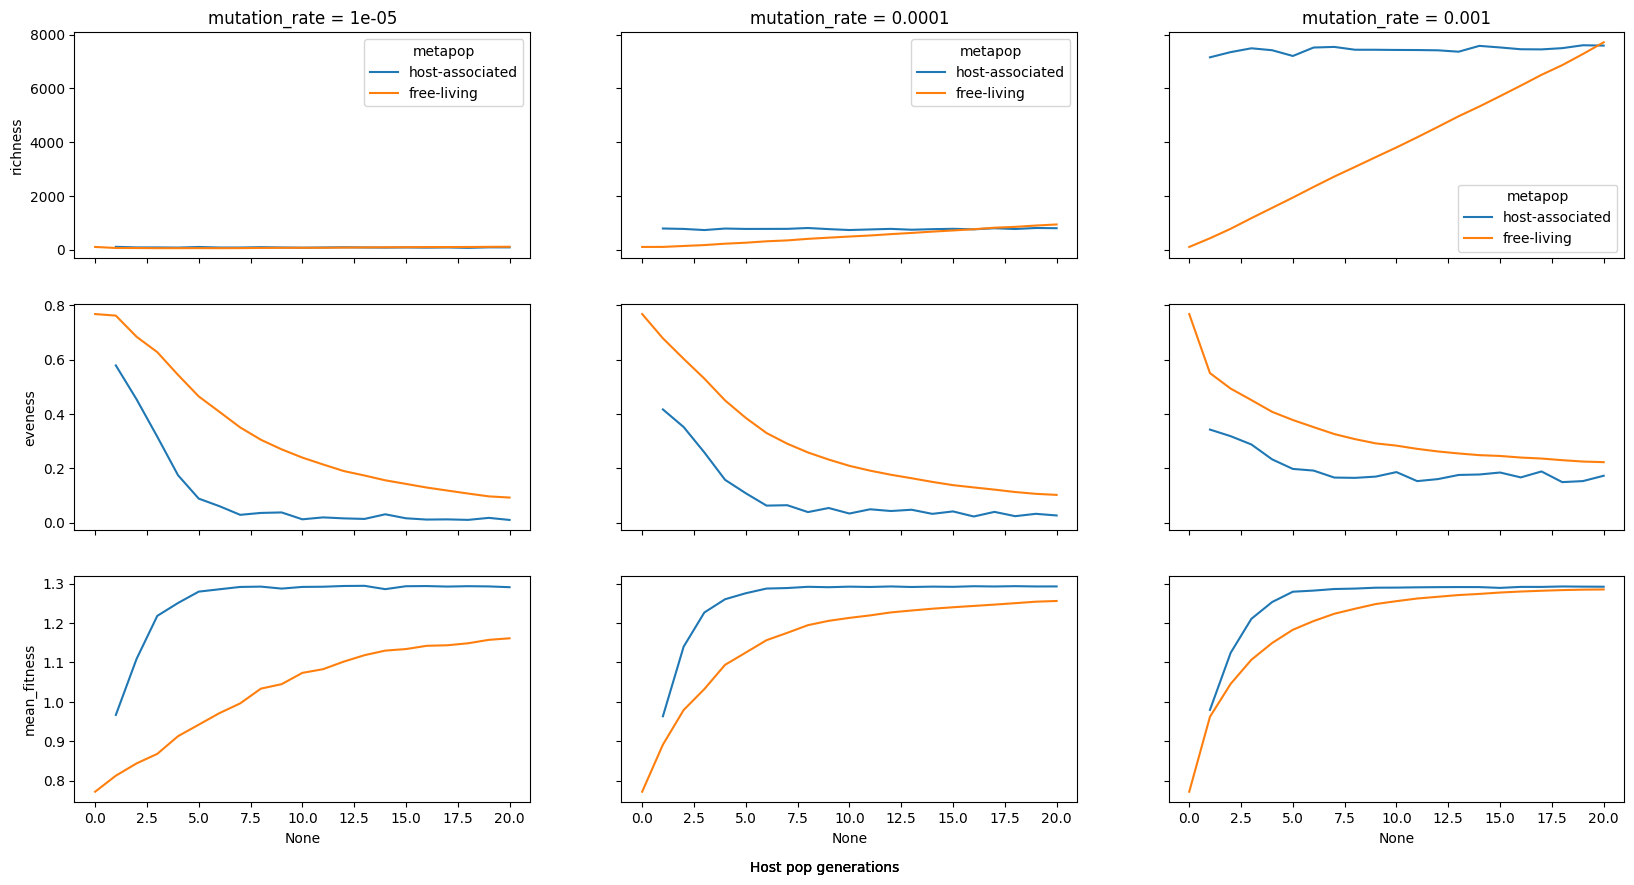

In [74]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from project_package.generate_pop import SymPop
import seaborn as sns

fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey='row')

i=0

df=time_df[(time_df.n_worms==100) & (time_df.cpus==10)]
df['mutation_rate']=[1E-12,1E-11,1E-10,1E-09,1E-06,1E-03,1E-04,1E-05]
mydf=df.melt(id_vars=['test','n_worms','cpus','mutation_rate'])

for mytest in mydf[mydf.variable=='run_time'].sort_values('mutation_rate').test.values[-3:]:
    mutation_rate=mydf[mydf.test==mytest].mutation_rate.values[0]
    with open('/home/qiulab/data/CRF_project/scratch/Modeling_trophosome/Scaling_up_investigation/2025_10_28/'+mytest+'.time_series_hostassociated.graphs.pickledump', 'rb') as handle:
      time_series_hostassociated=pickle.loads(handle.read())
        
    with open('/home/qiulab/data/CRF_project/scratch/Modeling_trophosome/Scaling_up_investigation/2025_10_28/'+mytest+'.time_series_freeliving.graphs.pickledump', 'rb') as handle:
      time_series_freeliving=pickle.loads(handle.read())
    
    df=pd.DataFrame()
    for trial in time_series_freeliving.keys():
    
        time_series_hostassociated[trial][0]=nx.Graph(abundance=0)
        df2=pd.DataFrame([[SymPop(G).eveness, SymPop(G).mean_fitness, SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                                columns=['eveness','mean_fitness','pop_size','richness','metapop','trial'])
        df=pd.concat([df, df2])
    
        # if trial==0:
        #     continue
        df3=pd.DataFrame([[SymPop(G).eveness, SymPop(G).mean_fitness, SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                                columns=['eveness','mean_fitness','pop_size','richness','metapop','trial'])
        df=pd.concat([df, df3])
    
    axes[0,i].set_title('mutation_rate = '+str(mutation_rate))
    sns.lineplot(ax=axes[0,i], data=df[(df.pop_size>0)],x=df[(df.pop_size>0)].index,y='richness',hue='metapop',legend=True)
    sns.lineplot(ax=axes[1,i], data=df[(df.pop_size>0) & ~(df.eveness.isna())],x=df[(df.pop_size>0) & ~(df.eveness.isna())].index,y='eveness',hue='metapop',legend=False)
    sns.lineplot(ax=axes[2,i], data=df[(df.pop_size>0)],x=df[(df.pop_size>0)].index,y='mean_fitness',hue='metapop',legend=False)
    fig.text(0.5, 0.04, 'Host pop generations', ha='center')


    i+=1


    


/tmp/ipykernel_395135/1059071298.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mutation_rate']=[1E-12,1E-11,1E-10,1E-09,1E-06,1E-03,1E-04,1E-05]
/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qiulab/.conda/envs/mamba/envs/maeva_env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/qiulab/CRF_project/work/Modeling_trophosome/notebooks/../src/project_package/generate_pop.py:129: RuntimeWarning: divide by zero encountered in log
  self.eveness=self.Shannon/np.log(self.richness)
/h

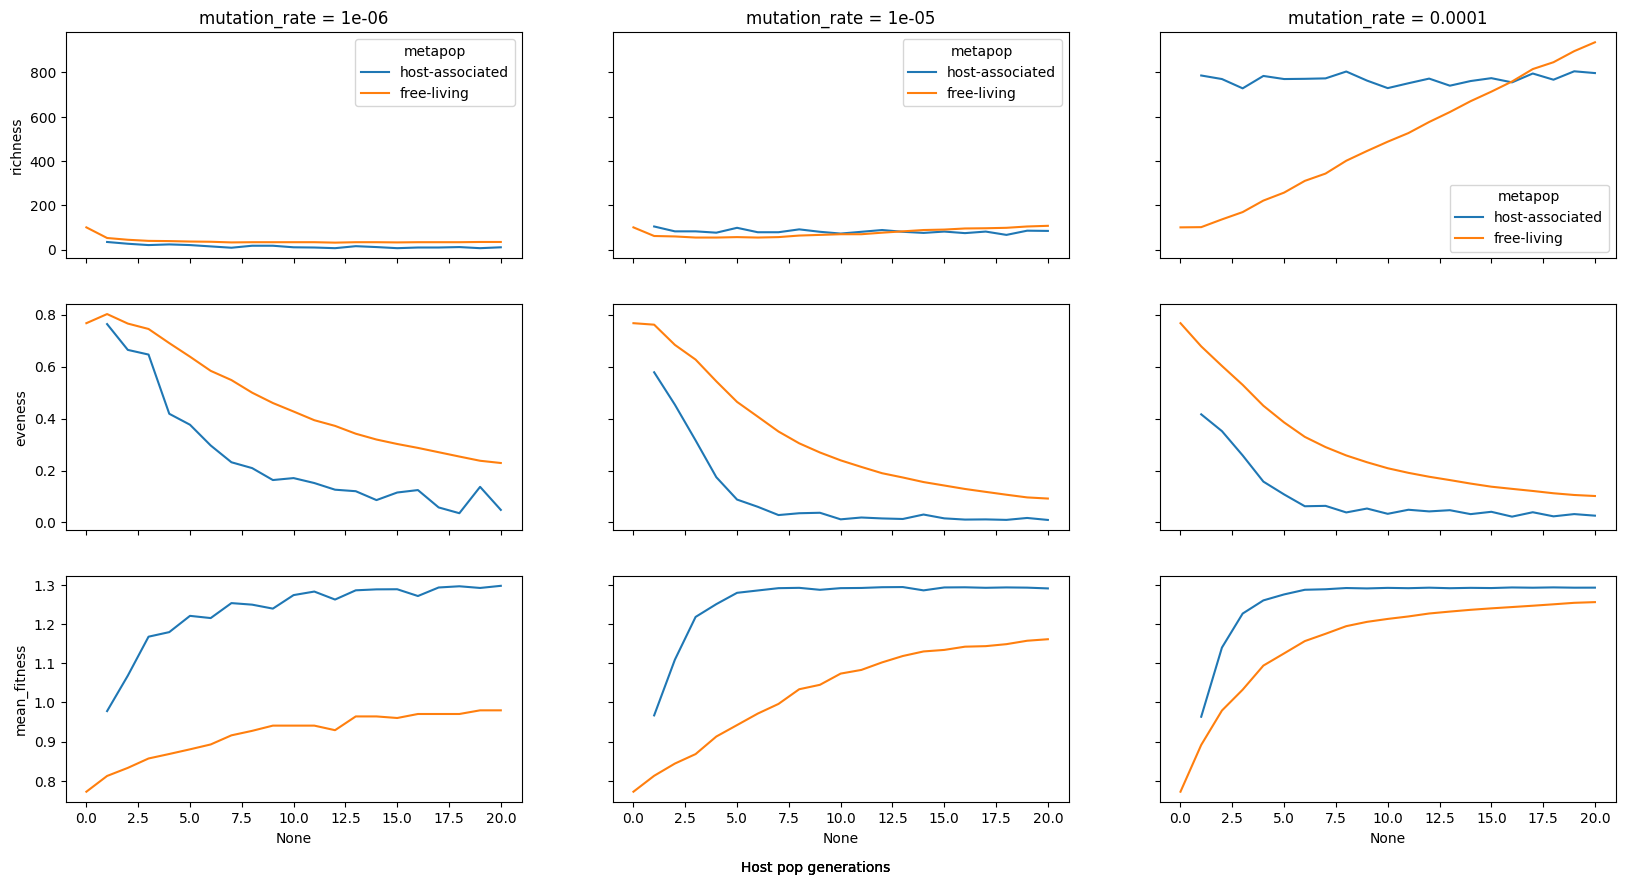

In [82]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from project_package.generate_pop import SymPop
import seaborn as sns

fig, axes = plt.subplots(3, 3, figsize=(20, 10), sharex=True, sharey='row')

i=0

df=time_df[(time_df.n_worms==100) & (time_df.cpus==10)]
df['mutation_rate']=[1E-12,1E-11,1E-10,1E-09,1E-06,1E-03,1E-04,1E-05]
mydf=df.melt(id_vars=['test','n_worms','cpus','mutation_rate'])

for mytest in mydf[mydf.variable=='run_time'].sort_values('mutation_rate').test.values[-4:-1]:
    mutation_rate=mydf[mydf.test==mytest].mutation_rate.values[0]
    with open('/home/qiulab/data/CRF_project/scratch/Modeling_trophosome/Scaling_up_investigation/2025_10_28/'+mytest+'.time_series_hostassociated.graphs.pickledump', 'rb') as handle:
      time_series_hostassociated=pickle.loads(handle.read())
        
    with open('/home/qiulab/data/CRF_project/scratch/Modeling_trophosome/Scaling_up_investigation/2025_10_28/'+mytest+'.time_series_freeliving.graphs.pickledump', 'rb') as handle:
      time_series_freeliving=pickle.loads(handle.read())
    
    df=pd.DataFrame()
    for trial in time_series_freeliving.keys():
    
        time_series_hostassociated[trial][0]=nx.Graph(abundance=0)
        df2=pd.DataFrame([[SymPop(G).eveness, SymPop(G).mean_fitness, SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                                columns=['eveness','mean_fitness','pop_size','richness','metapop','trial'])
        df=pd.concat([df, df2])
    
        # if trial==0:
        #     continue
        df3=pd.DataFrame([[SymPop(G).eveness, SymPop(G).mean_fitness, SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                                columns=['eveness','mean_fitness','pop_size','richness','metapop','trial'])
        df=pd.concat([df, df3])
    
    axes[0,i].set_title('mutation_rate = '+str(mutation_rate))
    sns.lineplot(ax=axes[0,i], data=df[(df.pop_size>0)],x=df[(df.pop_size>0)].index,y='richness',hue='metapop',legend=True)
    sns.lineplot(ax=axes[1,i], data=df[(df.pop_size>0) & ~(df.eveness.isna())],x=df[(df.pop_size>0) & ~(df.eveness.isna())].index,y='eveness',hue='metapop',legend=False)
    sns.lineplot(ax=axes[2,i], data=df[(df.pop_size>0)],x=df[(df.pop_size>0)].index,y='mean_fitness',hue='metapop',legend=False)
    fig.text(0.5, 0.04, 'Host pop generations', ha='center')


    i+=1


    
